In [75]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score


In [76]:
# Load dataset
df = pd.read_csv('../data/data.csv')


In [77]:
# Basic overview
print(df.shape)
print(df.info())
print(df["Experience_Level"].value_counts())

(973, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-n

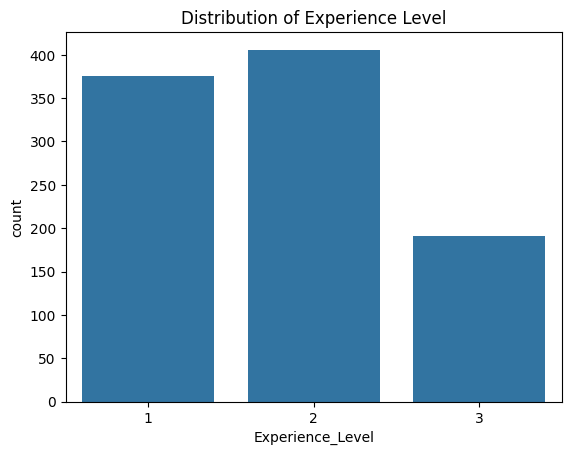

In [78]:
# Plot distribution of the target
from matplotlib import pyplot as plt
import seaborn as sns

sns.countplot(x="Experience_Level", data=df)
plt.title("Distribution of Experience Level")
plt.show()

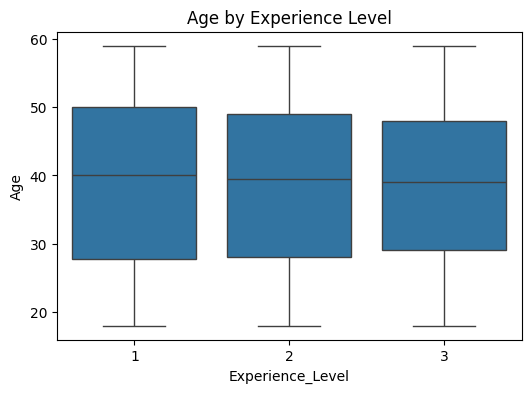

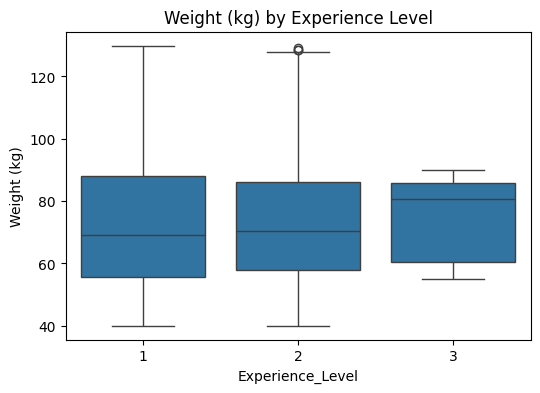

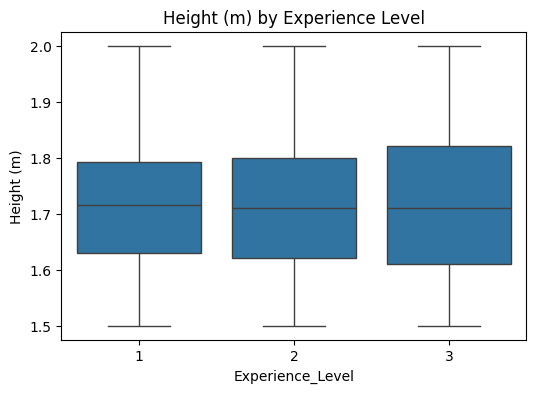

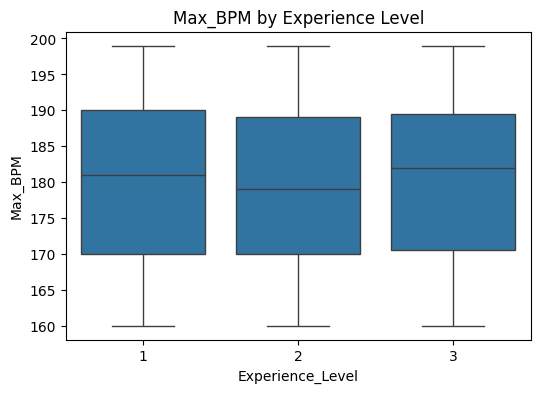

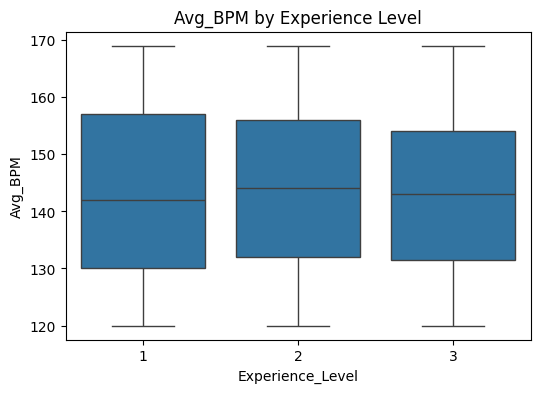

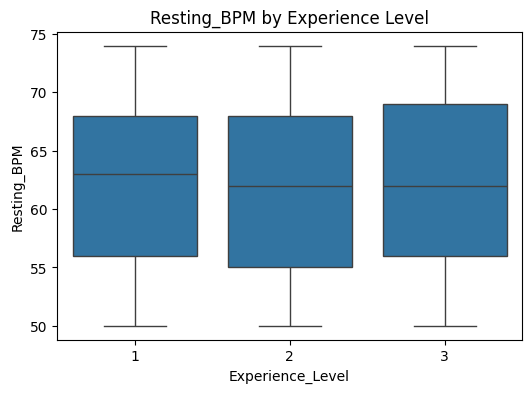

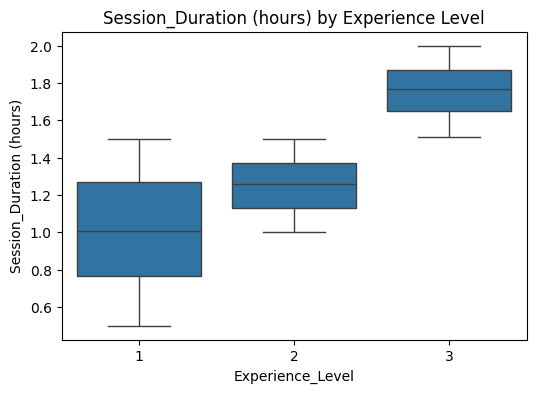

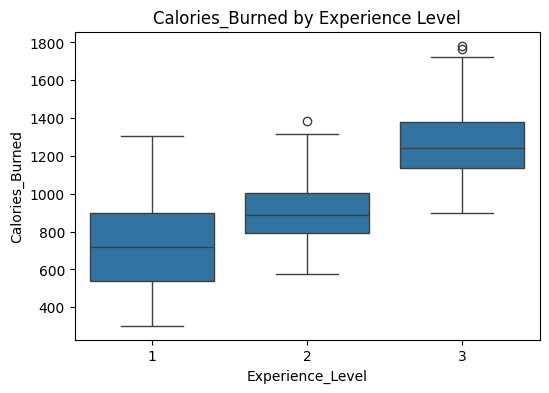

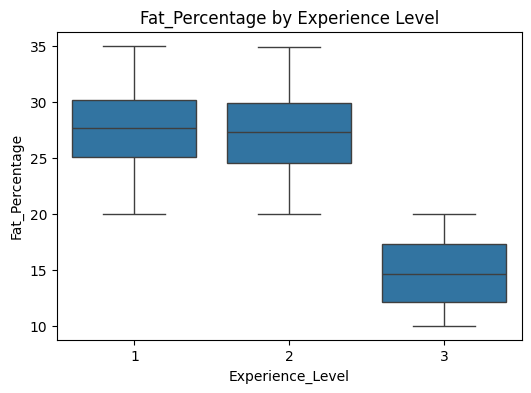

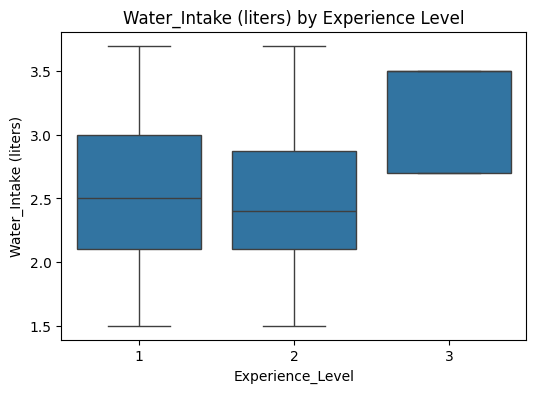

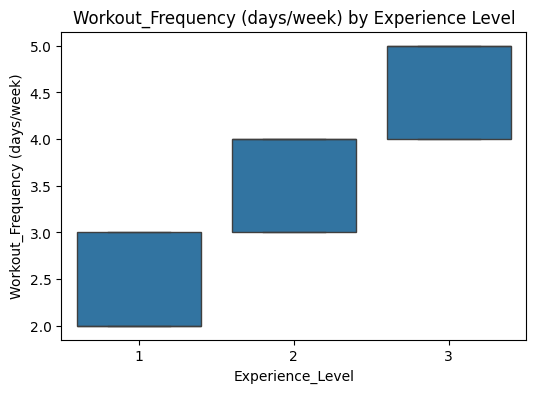

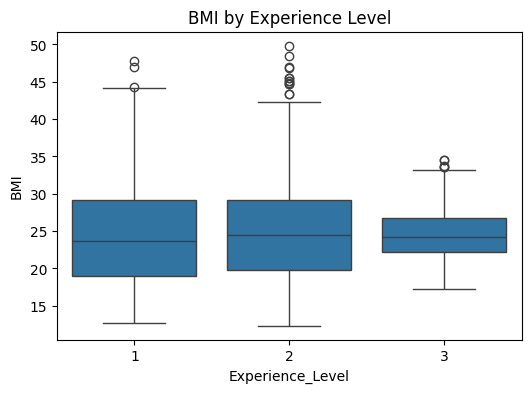

In [79]:
# Boxplots of numerical features grouped by Experience Level
num_cols = df.select_dtypes(include='number').columns.drop("Experience_Level", errors='ignore')
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Experience_Level", y=col, data=df)
    plt.title(f"{col} by Experience Level")
    plt.show()

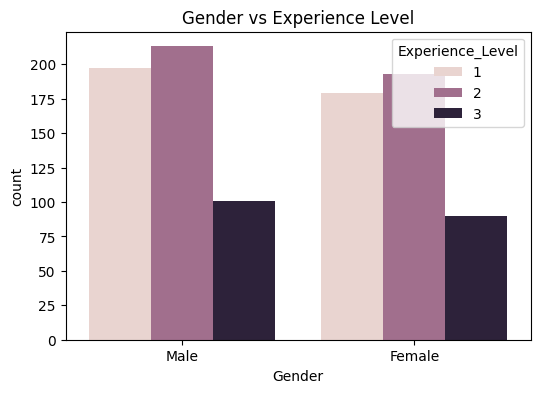

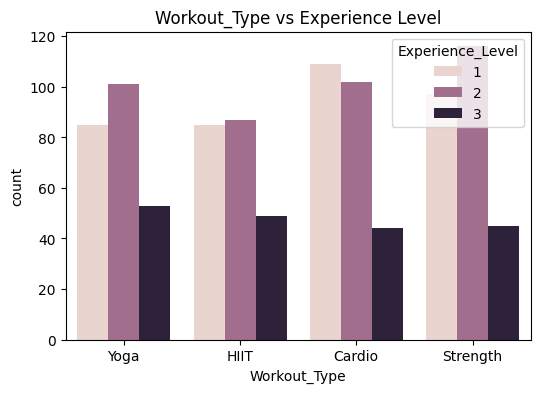

In [80]:

# Categorical variable distribution vs Experience Level
cat_cols = ["Gender", "Workout_Type"]
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue="Experience_Level", data=df)
    plt.title(f"{col} vs Experience Level")
    plt.show()

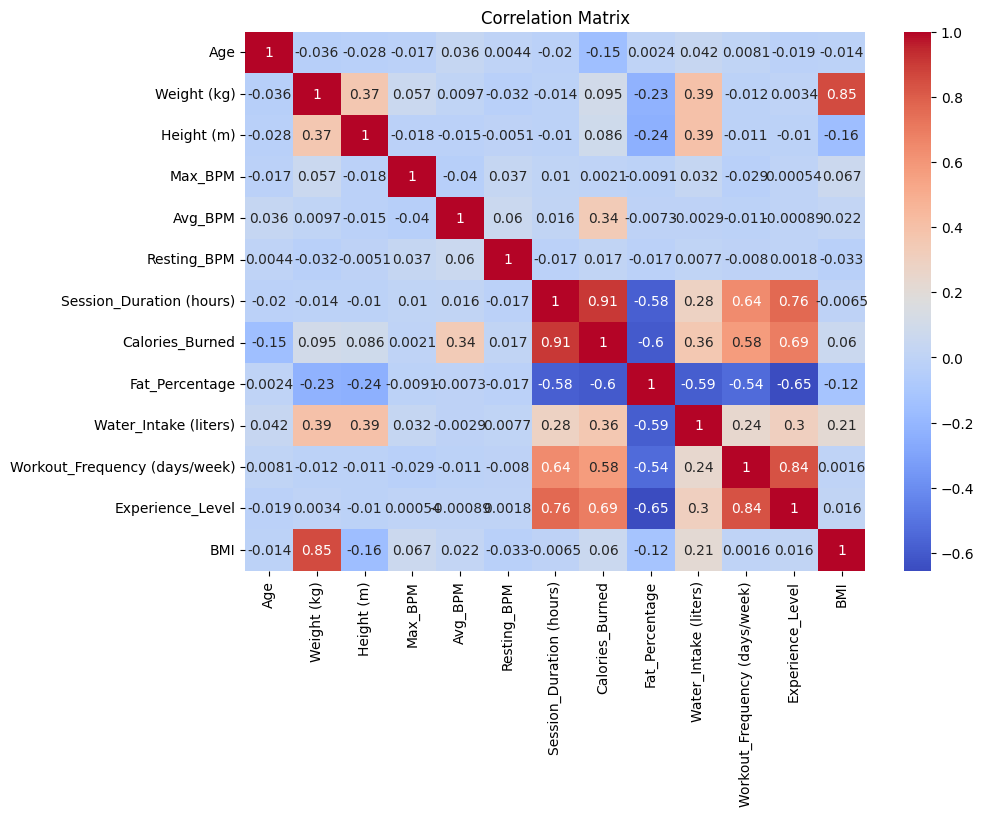

In [81]:
# Correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [82]:
# Encode 'Experience_Level' if it's categorical
if df['Experience_Level'].dtype == 'object':
    le_target = LabelEncoder()
    df['Experience_Level'] = le_target.fit_transform(df['Experience_Level'])

# Map encoded values into 3 classes: Beginner, Intermediate, Advanced
def map_to_three_classes(x):
    if x <= 1:
        return 0  # Beginner
    elif x == 2:
        return 1  # Intermediate
    else:
        return 2  # Advanced

df['Experience_Level'] = df['Experience_Level'].apply(map_to_three_classes)


In [83]:
df = pd.get_dummies(df, columns=['Gender', 'Workout_Type'], drop_first=True)


In [84]:
# Separate features and target
X = df.drop(columns=['Experience_Level'])
y = df['Experience_Level']

# Select top 5 features
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X, y)

# Get names of selected features
selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))


Selected Features: ['Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)']


In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.25, random_state=42, stratify=y
)


In [86]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

# Train and evaluate each model
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Predict
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Evaluate
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    # Cross-validation (5 folds)
    cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')

    # Display results
    print(f"\n{name} Results:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy:  {test_acc:.4f}")
    print(f"Cross-Val Accuracy (5 folds): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



Random Forest Results:
Training Accuracy: 1.0000
Testing Accuracy:  0.8934
Cross-Val Accuracy (5 folds): 0.8849 ± 0.0254

Gradient Boosting Results:
Training Accuracy: 0.9918
Testing Accuracy:  0.8648
Cross-Val Accuracy (5 folds): 0.8818 ± 0.0284


In [87]:


# Split data (same as before)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.25, random_state=42, stratify=y
)

# Train Gradient Boosting with stronger regularization
gb_model = GradientBoostingClassifier(
    n_estimators=500,          # more trees
    learning_rate=0.01,        # smaller step size
    max_depth=2,               # shallower trees
    min_samples_leaf=10,       # bigger leaves
    random_state=42
)

gb_model.fit(X_train, y_train)

# Predictions and accuracy
train_pred = gb_model.predict(X_train)
test_pred = gb_model.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

cv_scores = cross_val_score(gb_model, X_selected, y, cv=5, scoring='accuracy')

print("Gradient Boosting Results :")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Cross-Val Accuracy (5 folds): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Gradient Boosting Results :
Training Accuracy: 0.9095
Testing Accuracy:  0.9139
Cross-Val Accuracy (5 folds): 0.8993 ± 0.0245


In [88]:


# Save Gradient Boosting model (assume it’s the best)
joblib.dump(models["Gradient Boosting"], '../models/experience-level/experience_level_model.joblib')

# Save the label map manually (since you mapped manually to 0/1/2)
label_map = {0: "Beginner", 1: "Intermediate", 2: "Advanced"}
joblib.dump(label_map, '../models/experience-level/experience_level_map.joblib')

# Save selected feature names
joblib.dump(list(selected_features), '../models/experience-level/selected_features_experience_level.joblib')



['../models/experience-level/selected_features_experience_level.joblib']

In [89]:


# Load model and label map
model = joblib.load('../models/experience-level/experience_level_model.joblib')
label_map = joblib.load('../models/experience-level/experience_level_map.joblib')
selected_features = joblib.load('../models/experience-level/selected_features_experience_level.joblib')

# Custom test data (same features used during training)
print(selected_features)
custom_data = pd.DataFrame([
    [1.5, 1300, 15.2, 2.5, 4],
    [0.7, 600, 30.0, 1.8, 2],
    [1.2, 1100, 20.5, 2.2, 3],
    [0.9, 750, 25.1, 2.0, 3],
    [0, 200, 18.3, 2.7, 2],
], columns=selected_features)

# Predict using model
predicted_classes = model.predict(custom_data)

# Map numerical predictions to readable class names
predicted_labels = [label_map[int(cls)] for cls in predicted_classes]

# Display results
for i, label in enumerate(predicted_labels, 1):
    print(f"Custom Sample {i}: Predicted Experience Level = {label}")


['Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)']
Custom Sample 1: Predicted Experience Level = Intermediate
Custom Sample 2: Predicted Experience Level = Beginner
Custom Sample 3: Predicted Experience Level = Intermediate
Custom Sample 4: Predicted Experience Level = Beginner
Custom Sample 5: Predicted Experience Level = Beginner


c:\Users\yine6\OneDrive\Bureau\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
